
## To do 

1. Implement redundancy metric
1. Design a master metric = some combination of metrics + regularization (esp for max_df) 
1. Distribution difference metric changes:
    - Calculate the cosine distance from the vector of original frequencies instead of the uniform distribution
    - Calculate the cosine distance from the all 1s vector
1. what hyperparameter should create a greater change in in cosine / doc_freq?  or are those not capturing the difference in distribution?


Hyperparams

1. instead of using regular max_df as cutoff use max_df across subjects as filter? 
    - calculate df(data) vs df(nonprofit) & count(data) vs count(nonprofit) to use as baseline
1. try using hidden layer for the regression



1. **double check changing `data_joining.py` did not mess up any indexing**
1. *optimization:* do not append to dataframes, start w/ lists and convert to dataframe OR initialize a numpy matrix for the hyperparameters using np.empty first and then [populate instead of appending](https://stackoverflow.com/questions/13370570/elegant-grid-search-in-python-numpy)
1. See what aspects of unsupervised methods notebook you can incorporate

--- 

#### Notes

- cosine distance - measure between "behaviorly informed predicted keywords and true course description" 
- avoid human inspection as metric for now

### Completed

1. [x] Implement document frequency metric
1. [x] Change from cosine similarity to cosine distance
1. [x] combine keyword research notebooks and have a separate grid_search notebook + clean up training repo
1. [x] Rename columns to recall@max_len, precision@10 
1. [x] fix [settingWithCopyError](https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas) 
    

### max_df is a fixed hyperparameter that needs to be part of the grid search, what should the default level be?

- max document frequency = removing corpus-specific stop words
- what does this error mean `ValueError: max_df corresponds to < documents than min_df` and why does it occur was max_df = 0?

### does getting bigrams and trigrams separately make a difference?

- try getting the vocab using ngram_range = 1,3 and no limit on max_features


## remark: 
- maybe calculate recall using stemmed words (e.g. economy vs economist?)
- in this function remove stop words from the description & title + stem the words

## move these functions to a script and then import 

- doesn't work? 

max_df = 1.0 (**NEEDS TO BE 1.0 OTHERWISE IT'S NOT TREATED AS A PERCENTAGE and you "ignore words that only appear in more than 1 document" so you get all the esoteric words that only appear in one course description**)

### double check this is the correct way to make predictions on the test set and make sure you understand what information is contained in `sorted_frame` 
- does predicted_word_1 correspond to the highest probability?
- how does it index into vocab frame when vocab was obtained across all the descriptions?  no, it's only from the training set

---

In [27]:
import time
import os
import pandas as pd
import numpy as np
from collections import Counter
from itertools import chain
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)
pd.options.mode.chained_assignment = None 

TRAINING_DIR = os.getcwd()
vectorfile = os.path.join(TRAINING_DIR, 'course_vecs.tsv')
infofile = os.path.join(TRAINING_DIR, 'course_info.tsv')
textcolumn = 'course_description'

In [28]:
TRAINING_DIR = os.getcwd()
DATA_DIR = './data'
vectorfile = os.path.join(DATA_DIR, 'course_vecs.tsv')
infofile = os.path.join(DATA_DIR, 'course_info.tsv')
textcolumn = 'course_description'
num_top_words = 10
use_idf = True
tf_bias = .5
num_epochs = 5
max_df = 0.0028

In [29]:
def predict(course_vecs, course_descipts, trained_weights, trained_biases, num_words_per_course):
    """
    lalalal
    
    """
    df_with_keywords = course_descipts.copy()
    softmax_frame = course_vecs.iloc[:,1:].dot(trained_weights.values) + trained_biases # make predictions

    # From the softmax predictions, save the top 10 predicted words for each data point
    print('[INFO] Sorting classification results...')
    sorted_frame = np.argsort(softmax_frame,axis=1).iloc[:,-num_words_per_course:]

    print('[INFO] Predicting top k inferred keywords for each course...')
    for i in range(num_words_per_course):
        new_col = vocab_frame.iloc[sorted_frame.iloc[:,i],0] # get the ith top vocab word for each entry
        df_with_keywords['predicted_word_' + str(num_words_per_course-i)] = new_col.values
        
    return df_with_keywords

def calculate_metric(df_with_keywords, metric):
    """
    metrics: {r: recall, p: precision}
    """
    def clean_descrip_title(row):
        punc_remover = str.maketrans('', '', string.punctuation)
        lowered = row['descrip_title'].lower()
        lowered_removed_punc = lowered.translate(punc_remover)
        cleaned_set = set(lowered_removed_punc.split())
        return cleaned_set

    def recall_keywords(row):
        return row['description_title_set'].intersection(row['course_keywords_set'])
    
    prediction_df = df_with_keywords.copy()
    only_predicted_keywords_df = prediction_df[prediction_df.columns.difference(['course_name', 'course_title', 'course_description', 'course_subject', 'course_alternative_names'])]
    num_keywords_predicted_per_course = only_predicted_keywords_df.shape[1]
    prediction_df['course_keywords'] = only_predicted_keywords_df.iloc[:,:].apply(lambda x: ', '.join(x), axis=1)
    prediction_df = prediction_df[['course_name', 'course_title', 'course_description', 'course_keywords', 'course_alternative_names']]
    prediction_df['course_keywords'] = prediction_df['course_keywords'].apply(lambda keywords: ', '.join(sorted(set([word.strip() for word in keywords.split(',')]))))
    prediction_df['course_keywords_set'] = prediction_df['course_keywords'].apply(lambda keywords: (set([word.strip() for word in keywords.split(',')])))
    prediction_df['descrip_title'] = prediction_df['course_title'] + ' ' + prediction_df['course_description']
    prediction_df['description_title_set'] = prediction_df.apply(clean_descrip_title, axis = 1)
    prediction_df['shared_words'] = prediction_df.apply(recall_keywords, axis = 1)
    
    if metric == 'r':
        print('[INFO] Calculating Recall...')
        assert num_keywords_predicted_per_course == max_descript_len, 'Number of keywords predicted should equal longest description length'
        prediction_df['recall'] = prediction_df['shared_words'].apply(lambda words: len(list(words)) / max_descript_len)
        average_recall = np.mean(prediction_df['recall'])
        return average_recall
    if metric == 'p':
        print('[INFO] Calculating Precision...')
        assert num_keywords_predicted_per_course == num_top_words, 'Number of keywords predicted should equal number of predicted words per course'
        prediction_df['precision'] = prediction_df['shared_words'].apply(lambda words: len(list(words)) / num_top_words)
        average_precision = np.mean(prediction_df['precision'])
        return average_precision
    if metric == 'c':
        print('[INFO] Calculating Cosine Similarity Between Keyword Distributions...')
        predicted_keyword_list = only_predicted_keywords_df.values.tolist()
        predicted_keyword_list = list(chain.from_iterable(predicted_keyword_list))
        keyword_counter = Counter(predicted_keyword_list)
        print('[INFO] Most common keywords by count: ', keyword_counter.most_common(10))
        
        num_possible_keywords = df_with_keywords.shape[0] * num_top_words
        num_predicted_keywords = len(keyword_counter.keys())
        assert sum(keyword_counter.values()) == split_Y_valid.shape[0] * num_top_words,\
        'Total number of predicted keywords should equal number of courses * number of predicted keywords per course.'
        unif_keyword_vector = np.repeat(num_possible_keywords / num_predicted_keywords, num_predicted_keywords)
        predicted_keyword_vector = np.array(list(keyword_counter.values()))
        assert unif_keyword_vector.shape == predicted_keyword_vector.shape,\
        'Uniform keyword frequency vector should have same dimension as predicted keywords frequency vector.'
    
        cos_sim = cosine(predicted_keyword_vector, unif_keyword_vector)
        return cos_sim
    if metric == 'df':
        print('[INFO] Calculating Document Frequency of Predicted Keywords across Course Subjects...')
        document_df_cols = df_with_keywords.columns.difference(['course_title', 'course_description', 'course_name', 'course_alternative_names'])
        document_df = df_with_keywords.loc[:,document_df_cols]
        document_df.set_index('course_subject', inplace=True)
        
        document_dict = defaultdict(list)
        terms = set()
        for index, row in document_df.iterrows():
            document_dict[index].extend(row.values)
            terms.update(row.values)

        doc_freq_dict = defaultdict()
        num_docs = len(document_dict.keys())
        for term in terms:
            doc_freq_i = 0
            for key in document_dict.keys():
                if term in document_dict.get(key):
                    doc_freq_i += 1
            doc_freq_dict[term] = doc_freq_i / (num_docs)
            
        print('[INFO] Most common keywords by document frequencies: ', Counter(doc_freq_dict).most_common(10)) 
        average_document_frequency_score = np.mean(list(doc_freq_dict.values()))
        return average_document_frequency_score
        
def cosine_similarity(x, y):
    return 1 - cosine(x,y)


In [30]:
def get_vocab(dataframe, column):
    print("[INFO] Getting vocab...")

    dataframe[column] = dataframe[column].fillna('')
    
    # max_df_param = 0.0028  # 1.0 # 0.0036544883

    vectorizer = TfidfVectorizer(max_df = max_df, stop_words='english', ngram_range=(1,1), use_idf=use_idf)
    X = vectorizer.fit_transform(dataframe[column])
    unigrams = vectorizer.get_feature_names()
    print('[UNIGRAMS] Number of unigrams: %d' % (len(unigrams)))
    
    vectorizer = TfidfVectorizer(max_df = max_df, stop_words='english', ngram_range=(2,2), max_features=max(1, int(len(unigrams)/10)), use_idf=use_idf)
    X = vectorizer.fit_transform(dataframe[column])
    bigrams = vectorizer.get_feature_names()
    print('[BIGRAMS] Number of bigrams: %d' % (len(bigrams)))

    vectorizer = TfidfVectorizer(max_df = max_df, stop_words='english', ngram_range=(3,3), max_features=max(1, int(len(bigrams)/10)), use_idf=use_idf)
    X = vectorizer.fit_transform(dataframe[column])
    trigrams = vectorizer.get_feature_names()
    print('[TRIGRAMS] Number of trigrams: %d' % (len(trigrams)))

    vocab = np.concatenate((unigrams, bigrams, trigrams))
    vocab_list = list(vocab)
    removed_numbers_list = [word for word in vocab_list if not any(char.isdigit() for char in word)]
    vocab = np.array(removed_numbers_list)
#     pd.DataFrame(vocab).to_csv(outputfile+'_vocab.tsv', sep = '\t', encoding='utf-8', index = False)
    return vocab

In [31]:
def to_bag_of_words(dataframe, column, vocab):
    """Input: raw dataframe, text column, and vocabulary.
    Returns a sparse matrix of the bag of words representation of the column."""
    vectorizer = TfidfVectorizer(stop_words='english', vocabulary=vocab, use_idf=use_idf)
    X = vectorizer.fit_transform(dataframe[column].values.astype('U'))
    if tf_bias == -999:
        return X
    return (X.multiply(1/X.count_nonzero())).power(-tf_bias)

In [32]:
def logistic_regression(X, Y):
    print('[INFO] Performing logistic regression...')

    inputs = Input(shape=(X.shape[1],))
#     print('input shape: ', X.shape[1])  # 300 = number of cols in the feature matrix?
#     print('vocab size: ', vocabsize) # 2400 = len(get_vocab(raw_frame, textcolumn)) = num words parsed from description corpus
#     x = Dense(30, activation='sigmoid')(inputs)
#     predictions = Dense(vocabsize, activation='softmax')(x)
    predictions = Dense(vocabsize, activation='softmax')(inputs)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    model.fit(X, Y, epochs=num_epochs)
    weights = model.layers[1].get_weights()[0]
    biases = model.layers[1].get_weights()[1]
    weights_frame = pd.DataFrame(weights)
    biases_frame = pd.DataFrame(biases)
    return(weights_frame, biases)

In [33]:
def clean_descrip_title(row):
    punc_remover = str.maketrans('', '', string.punctuation)
    lowered = row['descrip_title'].lower()
    lowered_removed_punc = lowered.translate(punc_remover)
    cleaned_set = set(lowered_removed_punc.split())
    return cleaned_set

def recall_keywords(row):
    return row['description_title_set'].intersection(row['keywords_set'])

In [34]:
def test(x=1):
    print(x)
test()

1


In [35]:
f = lambda x=1: print(x)
f()

1


---

## 1-fold validation / only Train - test split for debugging

In [36]:
from sklearn.model_selection import train_test_split

vec_frame = pd.read_csv(vectorfile, sep = '\t') # Vector space representation of each user, all numeric
info_frame = pd.read_csv(infofile, sep = '\t') # Course information
info_frame.head()

,course_name,course_title,course_description,course_subject,course_alternative_names
0,Xart 98,Directed Group Study,This is a student-initiated course to be offer...,FPF-Art Practice,FPF-Art Practice 98 XART98
1,Xanthro 2ac,Introduction to Archaeology,Prehistory and cultural growth. Introduction t...,FPF-Anthropology,FPF-Anthropology 2AC XANTHRO2AC
2,Xstat 2,Introduction to Statistics,Population and variables. Standard measures of...,FPF-Statistics,FPF-Statistics 2 XSTAT2
3,Xmath 1b,Calculus,Continuation of 1A. Techniques of integration;...,FPF-Mathematics,FPF-Mathematics 1B XMATH1B
4,Xphilos 3,The Nature of Mind,Introduction to the philosophy of mind. Topics...,FPF-Philosophy,FPF-Philosophy 3 XPHILOS3


In [37]:
len(info_frame.course_subject.unique())

206

In [38]:
# info_frame['abbr_cid'] = info_frame.course_name.str.replace(' ', '_').str.upper()
# api_df = pd.read_csv('/home/matthew/Models-AskOski/shared/course_info.tsv', sep = '\t', ).drop(['Unnamed: 0', 'idx', 'updated_date'],axis=1)
# api_df.head(5) 
# any(api_df.course_subject.isnull())
# temp = pd.merge(info_frame, api_df, on='abbr_cid')[['course_name', 'course_title', 'course_description', 'course_alternative_names', 'course_subject']]


In [39]:
nonempty_indices = np.where(info_frame[textcolumn].notnull())[0]
filtered_vec_df = vec_frame.iloc[nonempty_indices,:].reset_index(drop = True)
filtered_descript_df = info_frame.iloc[nonempty_indices,:].reset_index(drop = True)
max_descript_len = max(filtered_descript_df.course_description.str.split().str.len())

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(filtered_vec_df, filtered_descript_df, test_size=0.2, random_state=42)

print(X_train.shape[0], X_test.shape[0])

5901 1476


In [41]:
vocab = get_vocab(Y_train, textcolumn) # get_vocab(raw_frame, textcolumn) 
vocab_frame = pd.DataFrame(vocab)
    
vocabsize = len(vocab)

# Convert the textcolumn of the raw dataframe into bag of words representation
Y_train_BOW = to_bag_of_words(Y_train, textcolumn, vocab)
Y_train_BOW = Y_train_BOW.toarray()
Y_train_BOW

[INFO] Getting vocab...
[UNIGRAMS] Number of unigrams: 11580
[BIGRAMS] Number of bigrams: 1158
[TRIGRAMS] Number of trigrams: 115


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
(weights_frame, biases) = logistic_regression(X_train.iloc[:,1:], Y_train_BOW)

[INFO] Performing logistic regression...
Epoch 1/5
5901/5901 [==============================] - 3s 474us/step - loss: 18861.4395 - acc: 0.0134
Epoch 2/5
5901/5901 [==============================] - 2s 286us/step - loss: 17395.1526 - acc: 0.0515
Epoch 3/5
5901/5901 [==============================] - 2s 286us/step - loss: 16529.8059 - acc: 0.0791
Epoch 4/5
5901/5901 [==============================] - 2s 289us/step - loss: 15801.0023 - acc: 0.0929
Epoch 5/5
5901/5901 [==============================] - 2s 291us/step - loss: 15172.5785 - acc: 0.1120


In [162]:
softmax_frame = X_test.iloc[:,1:].dot(weights_frame.values) + biases
print('[INFO] Sorting classification results...')
sorted_frame = np.argsort(softmax_frame,axis=1).iloc[:,-num_top_words:]

predicted_keyword_list = []
for i in range(num_top_words):
    new_col = vocab_frame.iloc[sorted_frame.iloc[:,i],0] # get the ith top vocab word for each entry
    predicted_keyword_list.extend(new_col.values)
    Y_test['predicted_word_' + str(num_top_words-i)] = new_col.values


[INFO] Sorting classification results...


In [196]:
Y_test.sample(5)

,course_name,course_title,course_description,course_subject,course_alternative_names,predicted_word_10,predicted_word_9,predicted_word_8,predicted_word_7,predicted_word_6,predicted_word_5,predicted_word_4,predicted_word_3,predicted_word_2,predicted_word_1
2288,Theater 52ac,Dance in American Cultures,Dance as a meaning-making expressive form. De...,Theater Dance & Perf Stds,Theater Dance & Perf Stds 52AC THEATER52AC,explorations,theatre,recording,formations,allowing,performing,performances,supplies,vocal,productions
6602,Slavic 138,Topics in Russian and Soviet Film,This course will examine the Russian contribut...,Slavic Languages & Lit,Slavic Languages & Lit 138 SLAVIC138,folklore,looking,aspect,soviet,beginner,avant,viewing,garde,russia,slavic
4483,Art 301,The Teaching of Art: Practice,Utilizing aspects of pedagogical and andragogi...,Art Practice,Art Practice 301 ART301,notion,communicating,centered,print,audience,avant,garde,performances,recording,talks
5321,Env sci 100,Introduction to the Methods of Environmental S...,Introduction to basic methods used in environm...,Environmental Sciences,Environmental Sciences 100 ENV SCI100,remote,fate,greatest,habitat,trip,insects,agricultural,wildlife,geologic,espm
5447,Nuc eng 221,Corrosion in Nuclear Power Systems,Structural metals in nuclear power plants; pro...,Nuclear Engineering,Nuclear Engineering 221 NUC ENG221,calculations,radioactive,fast,neutron,beam,fission,reactors,fuel,fusion,reactor


In [283]:
temp = Y_test[Y_test.columns.difference(['course_name', 'course_title', 'course_description', 'tf_bias', 'course_alternative_names'])]
temp.shape

(1476, 11)

In [207]:
doc_freq_df_cols = Y_test.columns.difference(['course_title', 'course_description', 'course_name', 'course_alternative_names'])
doc_df = Y_test.loc[:,doc_freq_df_cols]
test = doc_df.loc[doc_df.course_subject.str.contains('History')]
doc_df.set_index('course_subject', inplace=True)
doc_df.head()

,predicted_word_1,predicted_word_10,predicted_word_2,predicted_word_3,predicted_word_4,predicted_word_5,predicted_word_6,predicted_word_7,predicted_word_8,predicted_word_9
course_subject,,,,,,,,,,
Engineering,sponsoring,income,professionally,matlab,homework,layout,dependent,advisor,quickly,allocation
History,powers,rule,edu,russia,agricultural,rome,trace,evolved,looking,cold
Public Health,concern,survival,fertility,demographic,residents,demography,credential,influenced,multivariate,generalized
Evening & Weekend MBA,arbitrage,dependent,company,managed,workers,resulting,enabling,drug,practiced,diagnostic
History,did,socialism,powers,cold,rural,trace,formations,modernism,struggles,peace


In [208]:
from collections import defaultdict

In [209]:
test.set_index('course_subject', inplace=True)
test.head()

,predicted_word_1,predicted_word_10,predicted_word_2,predicted_word_3,predicted_word_4,predicted_word_5,predicted_word_6,predicted_word_7,predicted_word_8,predicted_word_9
course_subject,,,,,,,,,,
History,powers,rule,edu,russia,agricultural,rome,trace,evolved,looking,cold
History,did,socialism,powers,cold,rural,trace,formations,modernism,struggles,peace
History,iran,performing,france,did,crisis,west,evolved,supplies,enlightenment,republic
History of Art,economists,allocation,square,investigating,correlation,income,outcome,solubility,fair,optometric
History of Art,doe,france,listings,formations,audience,spain,desirable,ca,ideological,modernism


In [255]:
document_dict = defaultdict(list)
terms = set()
for index,row in doc_df.iterrows():
    document_dict[index].extend(row.values)
    terms.update(row.values)
# doc_freq_dict
len(terms)

1354

In [254]:
num_docs = len(document_dict.keys())
doc_freq_i = 0
for key in document_dict.keys():
    if 'performing' in document_dict.get(key):
        doc_freq_i += 1
#         print(doc_freq_i)
doc_freq_i / num_docs

0.6666666666666666

In [258]:
doc_freq_dict = defaultdict()
num_docs = len(document_dict.keys())
for term in terms:
    doc_freq_i = 0
#     print(term)
    for key in document_dict.keys():
        if term in document_dict.get(key):
            doc_freq_i += 1
    doc_freq_dict[term] = doc_freq_i / (num_docs)


In [271]:
Counter(doc_freq_dict).most_common(10)
# sorted(doc_freq_dict, key=doc_freq_dict.get, reverse=True)[:10]

[('powers', 0.2822085889570552),
 ('formations', 0.27607361963190186),
 ('performing', 0.25766871165644173),
 ('agricultural', 0.24539877300613497),
 ('trace', 0.22085889570552147),
 ('informed', 0.2147239263803681),
 ('crisis', 0.20245398773006135),
 ('did', 0.17791411042944785),
 ('modernism', 0.17791411042944785),
 ('recording', 0.17791411042944785)]

In [295]:
np.mean(list(doc_freq_dict.values()))

0.024354106442170894

In [195]:
from collections import Counter

keyword_counter = Counter(predicted_keyword_list)

keyword_counter.most_common(15)

[('trace', 150),
 ('powers', 148),
 ('formations', 133),
 ('agricultural', 111),
 ('performing', 108),
 ('struggles', 92),
 ('looking', 91),
 ('income', 90),
 ('authority', 86),
 ('crisis', 84),
 ('did', 80),
 ('chronological', 72),
 ('evolved', 71),
 ('modernism', 69),
 ('republic', 68)]

In [201]:
len(keyword_counter)

1354

In [18]:
dpt_file = infofile = os.path.join(TRAINING_DIR, 'academic_departments.tsv')
dpt_df = pd.read_csv(dpt_file, sep='\t')
dpt_df.head()

,ACADEMIC_DEPARTMENT_NAME,ACADEMIC_DIVISION_NAME,MAJOR_NAME,COLLEGE_NAME
0,African American Studies,L&S Social Sciences Division,Afr Amer Stds-Humanities,Clg of Letters & Science
1,African American Studies,L&S Social Sciences Division,Afr Amer Stds-Social Sci,Clg of Letters & Science
2,African American Studies,L&S Social Sciences Division,African American Studies,Clg of Letters & Science
3,Ag & Env Chem Grad Grp,Clg of Natural Resources,Ag & Environmental Chem,Clg of Natural Resources
4,Ag & Resource Econ & Pol,Clg of Natural Resources,Ag & Resource Economics,Clg of Natural Resources


In [20]:
dpt_df.loc[dpt_df.ACADEMIC_DEPARTMENT_NAME.str.contains('engineering', case=False)]

,ACADEMIC_DEPARTMENT_NAME,ACADEMIC_DIVISION_NAME,MAJOR_NAME,COLLEGE_NAME
15,Bioengineering,Clg of Engineering,Bioengineering,Clg of Engineering
16,Bioengineering,Clg of Engineering,Translational Medicine,Clg of Engineering
17,Bioengineering-UCSF Grad Grp,Clg of Engineering,Bioengineering (UCSF),Clg of Engineering
18,Bioengineering-UCSF Grad Grp,Clg of Engineering,Translational Medicine (UCSF),Clg of Engineering
70,Engineering Joint Programs,Clg of Engineering,BioE/MSE Joint Major,Clg of Engineering
71,Engineering Joint Programs,Clg of Engineering,EECS/MSE Joint Major,Clg of Engineering
72,Engineering Joint Programs,Clg of Engineering,EECS/NE Joint Major,Clg of Engineering
73,Engineering Joint Programs,Clg of Engineering,ME/NE Joint Major,Clg of Engineering
74,Engineering Joint Programs,Clg of Engineering,MSE/ME Joint Major,Clg of Engineering
75,Engineering Joint Programs,Clg of Engineering,MSE/NE Joint Major,Clg of Engineering


In [26]:
num_possible_keywords = Y_test.shape[0] * num_top_words
num_predicted_keywords = len(keyword_counter.keys())

In [27]:
assert sum(keyword_counter.values()) == Y_test.shape[0] * num_top_words,\
'Total number of predicted keywords should equal number of courses * number of predicted keywords per course.'

In [28]:
unif_keyword_vector = np.repeat(num_possible_keywords / num_predicted_keywords, num_predicted_keywords)
unif_keyword_vector

array([12.97012302, 12.97012302, 12.97012302, ..., 12.97012302,
       12.97012302, 12.97012302])

In [29]:
predicted_keyword_vector = np.array(list(keyword_counter.values()))
predicted_keyword_vector

array([41,  1,  1, ...,  2,  5, 48])

In [30]:
assert unif_keyword_vector.shape == predicted_keyword_vector.shape

In [31]:
from scipy.spatial.distance import cosine

def cosine_similarity(x, y):
    return 1 - cosine(x,y)

cosine_similarity(predicted_keyword_vector, unif_keyword_vector)

0.3620480643963293

In [ ]:
cosine_similarity([1,-1], [1,1])

---

Model evaluation:

1. Recall
1. Distribution
1. Tf-idf
1. Train each model on your courses & self-evaluate efficacy of keywords for categorizing (general) + efficacy for granular details (specific)

Possible Parameters for Grid Search:

- max_df (limit the commonly occuring words)  
- max_features (vocab size) 
- use_idf to set the weights as tf-idf instead of counts
- num_epochs 
- try training on subset? (no, the model needs to see every possible word it can predict)


## move these functions to a script and then import 

- doesn't work? 

Model evaluation:

1. Recall
1. Distribution
1. Tf-idf
1. Train each model on your courses & self-evaluate efficacy of keywords for categorizing (general) + efficacy for granular details (specific)

Possible Parameters for Grid Search:

- max_df (limit the commonly occuring words)  
- max_features (vocab size) 
- use_idf to set the weights as tf-idf instead of counts
- num_epochs 
- try training on subset? (no, the model needs to see every possible word it can predict)

### max_df is a fixed hyperparameter that needs to be part of the grid search, what should the default level be?

- max document frequency = removing corpus-specific stop words
- what does this error mean `ValueError: max_df corresponds to < documents than min_df` and why does it occur was max_df = 0?

### does getting bigrams and trigrams separately make a difference?

- try getting the vocab using ngram_range = 1,3 and no limit on max_features

### tf_bias is another fixed hyperparam that should be part of the grid search, default level is currently .5
- higher level = more specific

## remark: 
- maybe calculate recall using stemmed words (e.g. economy vs economist?)
- in this function remove stop words from the description & title + stem the words

## move these functions to a script and then import 

- doesn't work? 

In [4]:
# @timeout_decorator.timeout(600, exception_message='timeout occured at get_vocab')
def get_vocab(dataframe, column):
    print("[INFO] Getting vocab...")

    dataframe[column] = dataframe[column].fillna('')
    
    # max_df_param = 0.0028  # 1.0 # 0.0036544883

    vectorizer = TfidfVectorizer(max_df = max_df, stop_words='english', ngram_range=(1,1), use_idf=use_idf)
    X = vectorizer.fit_transform(dataframe[column])
    unigrams = vectorizer.get_feature_names()
    print('[INFO] Number of unigrams: %d' % (len(unigrams)))
    
    vectorizer = TfidfVectorizer(max_df = max_df, stop_words='english', ngram_range=(2,2), max_features=max(1, int(len(unigrams)/10)), use_idf=use_idf)
    X = vectorizer.fit_transform(dataframe[column])
    bigrams = vectorizer.get_feature_names()
    print('[INFO] Number of bigrams: %d' % (len(bigrams)))

    vectorizer = TfidfVectorizer(max_df = max_df, stop_words='english', ngram_range=(3,3), max_features=max(1, int(len(unigrams)/10)), use_idf=use_idf)
    X = vectorizer.fit_transform(dataframe[column])
    trigrams = vectorizer.get_feature_names()
    print('[INFO] Number of trigrams: %d' % (len(trigrams)))

    vocab = np.concatenate((unigrams, bigrams, trigrams))
    vocab_list = list(vocab)
    removed_numbers_list = [word for word in vocab_list if not any(char.isdigit() for char in word)]
    vocab = np.array(removed_numbers_list)
#     pd.DataFrame(vocab).to_csv(outputfile+'_vocab.tsv', sep = '\t', encoding='utf-8', index = False)
    return vocab

### tf_bias is another fixed hyperparam that should be part of the grid search, default level is currently .5
- higher level = more specific

## remark: 
- maybe calculate recall using stemmed words (e.g. economy vs economist?)
- in this function remove stop words from the description & title + stem the words

In [5]:
# @timeout_decorator.timeout(600, exception_message='timeout occured at to_bag_of_words')
def to_bag_of_words(dataframe, column, vocab):
    """Input: raw dataframe, text column, and vocabulary.
    Returns a sparse matrix of the bag of words representation of the column."""
    vectorizer = TfidfVectorizer(stop_words='english', vocabulary=vocab, use_idf=use_idf)
    X = vectorizer.fit_transform(dataframe[column].values.astype('U'))
    if tf_bias == -999:
        return X
    return (X.multiply(1/X.count_nonzero())).power(-tf_bias)

In [6]:
# @timeout_decorator.timeout(3600, exception_message='timeout occured at logistic_regression')
def logistic_regression(X, Y):
    print('[INFO] Performing logistic regression...')

    inputs = Input(shape=(X.shape[1],))
#     print('input shape: ', X.shape[1])  # 300 = number of cols in the feature matrix?
#     print('vocab size: ', vocabsize) # 2400 = len(get_vocab(raw_frame, textcolumn)) = num words parsed from description corpus
#     x = Dense(30, activation='sigmoid')(inputs)
#     predictions = Dense(vocabsize, activation='softmax')(x)
    predictions = Dense(vocabsize, activation='softmax')(inputs)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    model.fit(X, Y, epochs=num_epochs)
    weights = model.layers[1].get_weights()[0]
    biases = model.layers[1].get_weights()[1]
    weights_frame = pd.DataFrame(weights)
    biases_frame = pd.DataFrame(biases)
#     weights_frame.to_csv(outputfile+'_weights.tsv', sep = '\t', index = False)
#     biases_frame.to_csv(outputfile+'_biases.tsv', sep = '\t', index = False)
    return(weights_frame, biases)

In [7]:
def predict(course_vecs, course_descipts, trained_weights, trained_biases, num_words_per_course):
    """
    lalalal
    
    """
    df_with_keywords = course_descipts.copy()
    softmax_frame = course_vecs.iloc[:,1:].dot(trained_weights.values) + trained_biases # make predictions

    # From the softmax predictions, save the top 10 predicted words for each data point
    print('[INFO] Sorting classification results...')
    sorted_frame = np.argsort(softmax_frame,axis=1).iloc[:,-num_words_per_course:]

    print('[INFO] Predicting top k inferred keywords for each course...')
    for i in range(num_words_per_course):
        new_col = vocab_frame.iloc[sorted_frame.iloc[:,i],0] # get the ith top vocab word for each entry
        df_with_keywords['predicted_word_' + str(num_words_per_course-i)] = new_col.values
        
    return df_with_keywords

In [8]:
def calculate_metric(df_with_keywords, metric):
    """
    metrics: {r: recall, p: precision}
    """
#     try: 
    prediction_df = df_with_keywords.copy()
    only_predicted_keywords_df = prediction_df[prediction_df.columns.difference(['course_name', 'course_title', 'course_description', 'tf_bias', 'course_alternative_names'])]
    num_keywords_predicted = only_predicted_keywords_df.shape[1]
    prediction_df['course_keywords'] = only_predicted_keywords_df.iloc[:,:].apply(lambda x: ', '.join(x), axis=1)
    prediction_df = prediction_df[['course_name', 'course_title', 'course_description', 'course_keywords', 'course_alternative_names']]
    prediction_df['course_keywords'] = prediction_df['course_keywords'].apply(lambda keywords: ', '.join(sorted(set([word.strip() for word in keywords.split(',')]))))
    prediction_df['course_keywords_set'] = prediction_df['course_keywords'].apply(lambda keywords: (set([word.strip() for word in keywords.split(',')])))
    prediction_df['descrip_title'] = prediction_df['course_title'] + ' ' + prediction_df['course_description']
    prediction_df['description_title_set'] = prediction_df.apply(clean_descrip_title, axis = 1)
    prediction_df['shared_words'] = prediction_df.apply(recall_keywords, axis = 1)

    if metric == 'r':
        print('[INFO] Calculating Recall...')
        assert num_keywords_predicted == max_descript_len, 'Number of keywords predicted should equal longest description length'
        prediction_df['recall'] = prediction_df['shared_words'].apply(lambda words: len(list(words)) / max_descript_len)
        average_recall = np.mean(prediction_df['recall'])
        return average_recall
    if metric == 'p':
        print('[INFO] Calculating Precision...')
        assert num_keywords_predicted == num_top_words, 'Number of keywords predicted should equal number of predicted words per course'
        prediction_df['precision'] = prediction_df['shared_words'].apply(lambda words: len(list(words)) / num_top_words)
        average_precision = np.mean(prediction_df['precision'])
        return average_precision
    if metric == 'c':
        print('[INFO] Calculating Cosine Similarity Between Keyword Distributions...')
        predicted_keyword_list = only_predicted_keywords_df.values.tolist()
        predicted_keyword_list = list(chain.from_iterable(predicted_keyword_list))
        keyword_counter = Counter(predicted_keyword_list)

        num_possible_keywords = df_with_keywords.shape[0] * num_top_words
        num_predicted_keywords = len(keyword_counter.keys())
        assert sum(keyword_counter.values()) == split_Y_valid.shape[0] * num_top_words,\
        'Total number of predicted keywords should equal number of courses * number of predicted keywords per course.'
        unif_keyword_vector = np.repeat(num_possible_keywords / num_predicted_keywords, num_predicted_keywords)
        predicted_keyword_vector = np.array(list(keyword_counter.values()))
        assert unif_keyword_vector.shape == predicted_keyword_vector.shape,\
        'Uniform keyword frequency vector should have same dimension as predicted keywords frequency vector.'

        cos_sim = cosine_similarity(predicted_keyword_vector, unif_keyword_vector)
        return cos_sim
#         raise ValueError("Specify which metric to calculate.")
#     except TypeError as err: 
#         print(err.args)

## remark: 
- maybe calculate recall using stemmed words (e.g. economy vs economist?)
- in this function remove stop words from the description & title + stem the words

In [9]:
def clean_descrip_title(row):
    punc_remover = str.maketrans('', '', string.punctuation)
    lowered = row['descrip_title'].lower()
    lowered_removed_punc = lowered.translate(punc_remover)
    cleaned_set = set(lowered_removed_punc.split())
    return cleaned_set

def recall_keywords(row):
    return row['description_title_set'].intersection(row['course_keywords_set'])

In [10]:
def cosine_similarity(x, y):
    return 1 - cosine(x,y)

---
## Experiment Attempt with 1 split

In [11]:
from sklearn.cross_validation import train_test_split

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
vec_frame = pd.read_csv(vectorfile, sep = '\t') # Vector space representation of each user, all numeric
raw_frame = pd.read_csv(rawfile, sep = '\t') # Course information

nonempty_indices = np.where(raw_frame[textcolumn].notnull())[0]
filtered_vec_df = vec_frame.iloc[nonempty_indices,:].reset_index(drop = True)
filtered_descript_df = raw_frame.iloc[nonempty_indices,:].reset_index(drop = True)

In [16]:
any(raw_frame[textcolumn].isnull())

True

At this point you can get the indices of the CV split and predict only on each subset

- No it's more complicated than that you have to fit the model only on the subsets first, but then not all the words will be in the prediction vocabulary
- Not necessarily a big deal

In [17]:
max_descript_index = filtered_descript_df.course_description.str.split().str.len().idxmax()
max_descript_len = max(filtered_descript_df.course_description.str.split().str.len())
max_descript_len

181

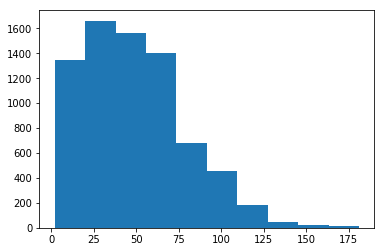

In [19]:
import matplotlib.pyplot as plt
description_lengths = filtered_descript_df.course_description.str.split().str.len()

plt.hist(description_lengths)
plt.show()

In [362]:
filtered_descript_df.loc[max_descript_index, 'course_description']

'After World War II, we witnessed a "revolution" in human rights theory, practice, and institution building. The implications of viewing individuals as equal and endowed with certain rights is potentially far reaching as in the declaration that individuals hold many of those rights irrespective of the views of their government. Yet, we also live in a world of sovereign states with sovereign state\'s rights. We see everyday a clash between the rights of the individual and lack of duty to fulfill those rights when an individual\'s home state is unwilling or unable to do so. After introducing the idea of human rights, its historic development and various international human rights mechanisms, this course will ask what post-World War II conceptions of human rights mean for a number of specific issues including humanitarian intervention, international criminal justice, U.S. foreign policy, immigration, and economic rights. Looking in-depth at these five areas, we will ask how ideas about hu

### should get_vocab be from entire dataset or just the train split?
- e.g. use all 13000 words or just 11000?
- makes more sense to just use the train split because that preserves the integrity of the split, you shouldn't use data from your test set to fit the model

max_df = .002

- [UNIGRAMS] number unigrams: 11608
- [BIGRAMS] number unigrams: 1160
- [TRIGRAMS] number unigrams: 1160

max_df = 1.0 (**NEEDS TO BE 1.0 OTHERWISE IT'S NOT TREATED AS A PERCENTAGE and you "ignore words that only appear in more than 1 document" so you get all the esoteric words that only appear in one course description**)
- [UNIGRAMS] number unigrams: 13270
- [BIGRAMS] number bigrams: 1327
- [TRIGRAMS] number trigrams: 1327
- (300, 15435)

In [521]:
X_train, X_test, Y_train, Y_test = train_test_split(filtered_vec_df, filtered_descript_df, test_size=0.2, random_state=42)

print(X_train.shape[0], X_test.shape[0])

5900 1476


In [522]:
vocab = get_vocab(Y_train, textcolumn) # get_vocab(raw_frame, textcolumn) 
vocab_frame = pd.DataFrame(vocab)
    
vocabsize = len(vocab)

# Convert the textcolumn of the raw dataframe into bag of words representation
Y_train_BOW = to_bag_of_words(Y_train, textcolumn, vocab)
Y_train_BOW = Y_train_BOW.toarray()
Y_train_BOW

[INFO] Getting vocab...
[INFO] Number of unigrams: 11608
[INFO] Number of bigrams: 1160
[INFO] Number of trigrams: 1160


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [523]:
# Train the coefficients for the vectorspace factors to predict the bag of words
# time_train_model_bf = time.time()

# Only train on instances with non-empty texts

(weights_frame, biases) = logistic_regression(X_train.iloc[:,1:], Y_train_BOW)
# Obtain the softmax predictions for all instances

[INFO] Performing logistic regression...
Epoch 1/5
5900/5900 [==============================] - 3s 568us/step - loss: 19122.8845 - acc: 0.0039
Epoch 2/5
5900/5900 [==============================] - 2s 326us/step - loss: 17952.5103 - acc: 0.0347
Epoch 3/5
5900/5900 [==============================] - 2s 334us/step - loss: 17293.3725 - acc: 0.0759
Epoch 4/5
5900/5900 [==============================] - 2s 334us/step - loss: 16661.2146 - acc: 0.0936
Epoch 5/5
5900/5900 [==============================] - 2s 330us/step - loss: 16069.7676 - acc: 0.1139


In [524]:
weights_frame.shape

(300, 13451)



### double check this is the correct way to make predictions on the test set and make sure you understand what information is contained in `sorted_frame` 
- does predicted_word_1 correspond to the highest probability?
- how does it index into vocab frame when vocab was obtained across all the descriptions?  no, it's only from the training set

In [513]:
df_with_keywords = predict(X_test, Y_test, weights_frame, biases, num_top_words)
df_with_keywords.head(2)

[INFO] Sorting classification results...
[INFO] Predicting top k inferred keywords for each course...


,course_name,course_title,course_description,course_alternative_names,predicted_word_10,predicted_word_9,predicted_word_8,predicted_word_7,predicted_word_6,predicted_word_5,predicted_word_4,predicted_word_3,predicted_word_2,predicted_word_1
1103,Engin 45,Properties of Materials,"Application of basic principles of physics and chemistry to the engineering properties of materials. Special emphasis devoted to relation between microstructure and the mechanical properties of metals, concrete, polymers, and ceramics, and the electrical properties of semiconducting materials. Sponsoring Department: Materials Science and Engineering",Engineering 45 ENGIN45,drug,metals,atomic,particles,astronomy,bulk,sufficient,kinetic,beam,polymers
2338,History 198bc,Berkeley Connect for Upper Division Students,"Berkeley Connect is a mentoring program, offered through various academic departments, that helps students build intellectual community. Over the course of a semester, enrolled students participate in regular small-group discussions facilitated by a graduate student mentor (following a faculty-directed curriculum), meet with their graduate student mentor for one-on-one academic advising, attend lectures and panel discussions featuring department faculty and alumni, and go on field trips to campus resources. Students are not required to be declared majors in order to participate.",History 198BC HISTORY198BC,http,violence,words,conquest,twentieth,called,powers,edu,peace,russia


In [575]:
calculate_metric(df_with_keywords, 'r')

[INFO] Calculating Recall...


AssertionError: Number of keywords predicted should equal longest description length

In [574]:
calculate_metric(df_with_keywords, 'p')

[INFO] Calculating Precision...


0.015322033898305085

In [525]:
# softmax_frame = X_test.iloc[:,1:].dot(weights_frame.values) + biases # make predictions

# From the softmax predictions, save the top 10 predicted words for each data point
print('[INFO] Sorting classification results...')
sorted_frame = np.argsort(softmax_frame,axis=1).iloc[:,-num_top_words:]

print('[INFO] Predicting top inferred keywords for each course...')
for i in range(num_top_words):
    new_col = vocab_frame.iloc[sorted_frame.iloc[:,i],0] # get the ith top vocab word for each entry
    Y_test['predicted_word_' + str(num_top_words-i)] = new_col.values

[INFO] Sorting classification results...
[INFO] Predicting top inferred keywords for each course...


In [516]:
# predict max_len number of words

# softmax_frame = X_test.iloc[:,1:].dot(weights_frame.values) + biases # make predictions

# # From the softmax predictions, save the top 10 predicted words for each data point
# print('[INFO] Sorting classification results...')
# sorted_frame = np.argsort(softmax_frame,axis=1).iloc[:,-max_descript_len:]

# for i in range(max_descript_len):
#     new_col = vocab_frame.iloc[sorted_frame.iloc[:,i],0] # get the ith top vocab word for each entry
#     Y_test['predicted_word_' + str(max_descript_len-i)] = new_col.values

[INFO] Sorting classification results...


In [526]:
Y_test.head(2)

,course_name,course_title,course_description,course_alternative_names,predicted_word_10,predicted_word_9,predicted_word_8,predicted_word_7,predicted_word_6,predicted_word_5,predicted_word_4,predicted_word_3,predicted_word_2,predicted_word_1
1103,Engin 45,Properties of Materials,"Application of basic principles of physics and chemistry to the engineering properties of materials. Special emphasis devoted to relation between microstructure and the mechanical properties of metals, concrete, polymers, and ceramics, and the electrical properties of semiconducting materials. Sponsoring Department: Materials Science and Engineering",Engineering 45 ENGIN45,drug,metals,atomic,particles,astronomy,bulk,sufficient,kinetic,beam,polymers
2338,History 198bc,Berkeley Connect for Upper Division Students,"Berkeley Connect is a mentoring program, offered through various academic departments, that helps students build intellectual community. Over the course of a semester, enrolled students participate in regular small-group discussions facilitated by a graduate student mentor (following a faculty-directed curriculum), meet with their graduate student mentor for one-on-one academic advising, attend lectures and panel discussions featuring department faculty and alumni, and go on field trips to campus resources. Students are not required to be declared majors in order to participate.",History 198BC HISTORY198BC,http,violence,words,conquest,twentieth,called,powers,edu,peace,russia


In [527]:
# def calculate_recall(df):
#     prediction_df = df.copy()
#     only_predicted_keywords_df = prediction_df[prediction_df.columns.difference(['course_name', 'course_title', 'course_description', 'tf_bias', 'course_alternative_names'])]
#     num_keywords_predicted = only_predicted_keywords_df.shape[1]
#     prediction_df['course_keywords'] = only_predicted_keywords_df.iloc[:,:].apply(lambda x: ', '.join(x), axis=1)
#     prediction_df = prediction_df[['course_name', 'course_title', 'course_description', 'course_keywords', 'course_alternative_names']]
#     prediction_df['course_keywords'] = prediction_df['course_keywords'].apply(lambda keywords: ', '.join(sorted(set([word.strip() for word in keywords.split(',')]))))
#     prediction_df['course_keywords_set'] = prediction_df['course_keywords'].apply(lambda keywords: (set([word.strip() for word in keywords.split(',')])))
#     prediction_df['descrip_title'] = prediction_df['course_title'] + ' ' + prediction_df['course_description']
#     prediction_df['description_title_set'] = prediction_df.apply(clean_descrip_title, axis = 1)
#     prediction_df['shared_words'] = prediction_df.apply(recall_keywords, axis = 1)
#     prediction_df['recall'] = prediction_df['shared_words'].apply(lambda words: len(list(words)) / max_descript_len)
#     fold_i_average_recall = np.mean(prediction_df['recall'])
#     return fold_i_average_recall

In [475]:
sorted_frame.head(2)

,13441,13442,13443,13444,13445,13446,13447,13448,13449,13450
1103,1256,7367,4211,920,6169,9469,5411,692,9597,7794
2338,1306,1168,4773,5950,11027,2019,3142,7439,7884,8988


In [476]:
softmax_frame.head(2)

,0,1,2,3,4,5,6,7,8,9,...,13441,13442,13443,13444,13445,13446,13447,13448,13449,13450
1103,-13.619102,-12.834158,-13.334953,-12.993541,-12.190391,-12.566942,-13.327277,-12.202205,-13.228280,-11.900171,...,-14.803132,-14.733360,-14.764064,-14.752999,-14.749906,-14.779751,-14.758421,-14.746018,-14.811518,-14.795294
2338,-22.217343,-20.583056,-21.253432,-21.003830,-19.247303,-20.695284,-21.758510,-20.265141,-21.447015,-18.852893,...,-24.730102,-24.618149,-24.645153,-24.560171,-24.575732,-24.695749,-24.655557,-24.585224,-24.689903,-24.599509


In [528]:
calculate_recall(Y_test)

0.024999999999999998

In [536]:
Y_test.head(2)

,course_name,course_title,course_description,course_alternative_names,predicted_word_10,predicted_word_9,predicted_word_8,predicted_word_7,predicted_word_6,predicted_word_5,predicted_word_4,predicted_word_3,predicted_word_2,predicted_word_1
1103,Engin 45,Properties of Materials,"Application of basic principles of physics and chemistry to the engineering properties of materials. Special emphasis devoted to relation between microstructure and the mechanical properties of metals, concrete, polymers, and ceramics, and the electrical properties of semiconducting materials. Sponsoring Department: Materials Science and Engineering",Engineering 45 ENGIN45,drug,metals,atomic,particles,astronomy,bulk,sufficient,kinetic,beam,polymers
2338,History 198bc,Berkeley Connect for Upper Division Students,"Berkeley Connect is a mentoring program, offered through various academic departments, that helps students build intellectual community. Over the course of a semester, enrolled students participate in regular small-group discussions facilitated by a graduate student mentor (following a faculty-directed curriculum), meet with their graduate student mentor for one-on-one academic advising, attend lectures and panel discussions featuring department faculty and alumni, and go on field trips to campus resources. Students are not required to be declared majors in order to participate.",History 198BC HISTORY198BC,http,violence,words,conquest,twentieth,called,powers,edu,peace,russia


In [487]:
predicted_keywords = Y_test[Y_test.columns.difference(['course_name', 'course_title', 'course_description', 'tf_bias', 'course_alternative_names'])]
Y_test['course_keywords'] = predicted_keywords.iloc[:,:].apply(lambda x: ', '.join(x), axis=1)
Y_test = Y_test[['course_name', 'course_title', 'course_description', 'course_keywords', 'course_alternative_names']]
Y_test['course_keywords'] = Y_test['course_keywords'].apply(lambda keywords: ', '.join(sorted(set([word.strip() for word in keywords.split(',')]))))
Y_test['course_keywords_set'] = Y_test['course_keywords'].apply(lambda keywords: (set([word.strip() for word in keywords.split(',')])))
Y_test.head(2)

,course_name,course_title,course_description,course_keywords,course_alternative_names,course_keywords_set
1103,Engin 45,Properties of Materials,"Application of basic principles of physics and chemistry to the engineering properties of materials. Special emphasis devoted to relation between microstructure and the mechanical properties of metals, concrete, polymers, and ceramics, and the electrical properties of semiconducting materials. Sponsoring Department: Materials Science and Engineering","astronomy, beam, bulk, gases, ion, matlab, particles, polymers, solar, sponsoring",Engineering 45 ENGIN45,"{beam, gases, polymers, matlab, particles, bulk, astronomy, ion, solar, sponsoring}"
2338,History 198bc,Berkeley Connect for Upper Division Students,"Berkeley Connect is a mentoring program, offered through various academic departments, that helps students build intellectual community. Over the course of a semester, enrolled students participate in regular small-group discussions facilitated by a graduate student mentor (following a faculty-directed curriculum), meet with their graduate student mentor for one-on-one academic advising, attend lectures and panel discussions featuring department faculty and alumni, and go on field trips to campus resources. Students are not required to be declared majors in order to participate.","boundaries, called, conquest, edu, http, looking, peace, powers, russia, west",History 198BC HISTORY198BC,"{looking, conquest, powers, peace, edu, russia, west, boundaries, called, http}"


In [553]:
predicted_keyword_list = predicted_keywords.values.tolist()
predicted_keyword_list = list(chain.from_iterable(predicted_keyword_list))

keyword_counter = Counter(predicted_keyword_list)

keyword_counter.most_common(10)

[('ocular', 322),
 ('professionally', 321),
 ('debt', 319),
 ('securities', 319),
 ('managerial', 319),
 ('formulating', 313),
 ('alliances', 308),
 ('optometric', 269),
 ('neurons', 258),
 ('managed', 212)]

In [488]:
Y_test['descrip_title'] = Y_test['course_title'] + ' ' + Y_test['course_description']
Y_test['description_title_set'] = Y_test.apply(clean_descrip_title, axis = 1)
Y_test['shared_words'] = Y_test.apply(recall_keywords, axis = 1)
Y_test['recall'] = Y_test['shared_words'].apply(lambda words: len(list(words)) / max_descript_len)
Y_test.head(5)

,course_name,course_title,course_description,course_keywords,course_alternative_names,course_keywords_set,descrip_title,description_title_set,shared_words,recall
1103,Engin 45,Properties of Materials,"Application of basic principles of physics and chemistry to the engineering properties of materials. Special emphasis devoted to relation between microstructure and the mechanical properties of metals, concrete, polymers, and ceramics, and the electrical properties of semiconducting materials. Sponsoring Department: Materials Science and Engineering","astronomy, beam, bulk, gases, ion, matlab, particles, polymers, solar, sponsoring",Engineering 45 ENGIN45,"{beam, gases, polymers, matlab, particles, bulk, astronomy, ion, solar, sponsoring}","Properties of Materials Application of basic principles of physics and chemistry to the engineering properties of materials. Special emphasis devoted to relation between microstructure and the mechanical properties of metals, concrete, polymers, and ceramics, and the electrical properties of semiconducting materials. Sponsoring Department: Materials Science and Engineering","{and, physics, relation, properties, devoted, concrete, the, semiconducting, emphasis, special, electrical, ceramics, sponsoring, science, department, basic, polymers, microstructure, materials, metals, between, application, chemistry, of, mechanical, principles, engineering, to}","{polymers, sponsoring}",0.01105
2338,History 198bc,Berkeley Connect for Upper Division Students,"Berkeley Connect is a mentoring program, offered through various academic departments, that helps students build intellectual community. Over the course of a semester, enrolled students participate in regular small-group discussions facilitated by a graduate student mentor (following a faculty-directed curriculum), meet with their graduate student mentor for one-on-one academic advising, attend lectures and panel discussions featuring department faculty and alumni, and go on field trips to campus resources. Students are not required to be declared majors in order to participate.","boundaries, called, conquest, edu, http, looking, peace, powers, russia, west",History 198BC HISTORY198BC,"{looking, conquest, powers, peace, edu, russia, west, boundaries, called, http}","Berkeley Connect for Upper Division Students Berkeley Connect is a mentoring program, offered through various academic departments, that helps students build intellectual community. Over the course of a semester, enrolled students participate in regular small-group discussions facilitated by a graduate student mentor (following a faculty-directed curriculum), meet with their graduate student mentor for one-on-one academic advising, attend lectures and panel discussions featuring department faculty and alumni, and go on field trips to campus resources. Students are not required to be declared majors in order to participate.","{build, and, field, berkeley, for, with, faculty, a, academic, featuring, the, offered, discussions, meet, in, required, order, through, helps, facilitated, resources, panel, graduate, that, curriculum, students, over, various, course, alumni, their, division, upper, department, attend, facultydirected, on, oneonone, lectures, departments, advising, be, mentoring, program, majors, student, are, trips, of, participate, campus, semester, not, is, intellectual, smallgroup, mentor, go, to, community, connect, by, declared, regular, enrolled, following}",{},0.00000
7196,Econ 224,Economics of Institutions,This course develops the proposition that institutions have pervasive ramifications for understanding economic organization. A comparative institutional approach is employed whereby the transaction is made the basic unit of analysis and alternative modes of organization are assessed with respect to their comparative contracting properties.,"allocation, capture, critiques, demonstrating, economists, goods, homework, leave, modeled, survival",Economics 224 ECON224,"{allocati

## what's the threshold for good recall?  
- varies wrt the vocabulary, can have higher recall but poor keywords, the evaluation metric should be in tandem with some **"relevancy"** metric

In [489]:
np.mean(Y_test.recall)

0.0013662429441973977

In [287]:
# Y_test[Y_test['recall'] > 0]

### end 1
---



## experiment attempt 2: with cross validation

In [20]:
kf = KFold(n_splits = 5, random_state = 42)

print('[INFO] Running cross validation...')

recall_validation_scores = []
precision_validation_scores = []
distribution_validation_scores = []
fold_num = 1
# X = vectors, Y = descriptions
for train_idx, valid_idx in kf.split(filtered_vec_df):
    print('[INFO] ****** Fold %d ******' % (fold_num))
    
    split_X_train, split_X_valid = filtered_vec_df.iloc[train_idx], filtered_vec_df.iloc[valid_idx]
    split_Y_train, split_Y_valid = filtered_descript_df.iloc[train_idx], filtered_descript_df.iloc[valid_idx]
    
    vocab = get_vocab(split_Y_train, textcolumn) 
    vocab_frame = pd.DataFrame(vocab)
    vocabsize = len(vocab)

    # Convert the textcolumn of the raw dataframe into bag of words representation
    split_Y_train_BOW = to_bag_of_words(split_Y_train, textcolumn, vocab)
    split_Y_train_BOW = split_Y_train_BOW.toarray()
    
    (weights_frame, biases) = logistic_regression(split_X_train.iloc[:,1:], split_Y_train_BOW)
    
    print('[INFO] Predicting on validation set for recall...')
    df_with_keywords = predict(split_X_valid, split_Y_valid, weights_frame, biases, max_descript_len)
    
    fold_i_average_recall = calculate_metric(df_with_keywords, 'r')
    recall_validation_scores.append(fold_i_average_recall)
    print('[INFO] Fold %d recall: %f.' % (fold_num, fold_i_average_recall))
    
    print('[INFO] Predicting on validation set for precision...')
    df_with_keywords = predict(split_X_valid, split_Y_valid, weights_frame, biases, num_top_words)
    fold_i_average_precision = calculate_metric(df_with_keywords, 'p')
    precision_validation_scores.append(fold_i_average_precision)
    print('[INFO] Fold %d precision: %f.' % (fold_num, fold_i_average_precision))
    
    fold_i_distribution_diff = calculate_metric(df_with_keywords, 'c')
    distribution_validation_scores.append(fold_i_distribution_diff)
    print('[INFO] Fold %d cosine similarity: %f.' % (fold_num, fold_i_distribution_diff))
    
    fold_num += 1
       
# print(f"Cosine Similarity: {distribution_cosine_sim_scores} \nRecall: {recall_validation_scores}")
precision_validation_scores

[INFO] Running cross validation...
[INFO] ****** Fold 1 ******
[INFO] Getting vocab...
[INFO] Number of unigrams: 11855
[INFO] Number of bigrams: 1185
[INFO] Number of trigrams: 1185
[INFO] Performing logistic regression...
Epoch 1/5
5900/5900 [==============================] - 3s 451us/step - loss: 19737.1038 - acc: 0.0042
Epoch 2/5
5900/5900 [==============================] - 2s 288us/step - loss: 18545.6686 - acc: 0.0395
Epoch 3/5
5900/5900 [==============================] - 2s 284us/step - loss: 17855.6044 - acc: 0.0753
Epoch 4/5
5900/5900 [==============================] - 2s 293us/step - loss: 17181.1920 - acc: 0.1032
Epoch 5/5
5900/5900 [==============================] - 2s 294us/step - loss: 16580.0680 - acc: 0.1147
[INFO] Predicting on validation set for recall...
[INFO] Sorting classification results...
[INFO] Predicting top k inferred keywords for each course...
[INFO] Calculating Recall...
[INFO] Fold 1 recall: 0.006360.
[INFO] Predicting on validation set for precision...


[0.029471544715447155,
 0.028610169491525426,
 0.025898305084745766,
 0.02305084745762712,
 0.014915254237288136]

In [559]:
distribution_validation_scores

[0.4598174502142759,
 0.4373838326840337,
 0.37181566231750807,
 0.348645018646041,
 0.2401963885567444]

In [533]:
recall_validation_scores

[0.0062023686535207885,
 0.006277741361550707,
 0.0056784343103286825,
 0.005341324094016293,
 0.003951680868995224]

In [23]:
recall_i = np.mean(recall_validation_scores)
precision_i = np.mean(precision_validation_scores)
distribution_diff_i = np.mean(distribution_validation_scores)

hyperparams_cols = ['tf-bias', 'max_df', 'num_epochs', 'num_top_words', 'recall', 'precision', 'distribution_diff']
hyperparams_df = pd.DataFrame(columns=hyperparams_cols)
model_i_info_list = [tf_bias, max_df, num_epochs, num_top_words, recall_i, precision_i, distribution_diff_i]

model_i_info_list

[0.5,
 0.0028,
 5,
 10,
 0.005563703654641191,
 0.02438922419732672,
 0.37175375639262154]

In [26]:
model_i_info = pd.DataFrame([model_i_info_list], columns=hyperparams_cols)
hyperparams_df = hyperparams_df.append(model_i_info, sort= False)

hyperparams_df

,tf-bias,max_df,num_epochs,num_top_words,recall,precision,distribution_diff
0,0.5,0.0028,5,10,0.005564,0.024389,0.371754


In [279]:
print('[INFO] Running cross validation...')

recall_validation_scores = []
distribution_cosine_sim_scores = []
fold_num = 1
# X = vectors, Y = descriptions
for train_idx, valid_idx in kf.split(filtered_vec_df):
    print('[INFO] Fold %d' % (fold_num))
    
    split_X_train, split_X_valid = filtered_vec_df.iloc[train_idx], filtered_vec_df.iloc[valid_idx]
    split_Y_train, split_Y_valid = filtered_descript_df.iloc[train_idx], filtered_descript_df.iloc[valid_idx]
    
    vocab = get_vocab(split_Y_train, textcolumn) 
    vocab_frame = pd.DataFrame(vocab)
    vocabsize = len(vocab)

    # Convert the textcolumn of the raw dataframe into bag of words representation
    Y_train_BOW = to_bag_of_words(split_Y_train, textcolumn, vocab)
    Y_train_BOW = Y_train_BOW.toarray()
    
    (weights_frame, biases) = logistic_regression(split_X_train.iloc[:,1:], Y_train_BOW)
    
    print('[INFO] Predicting on validation set...')
    softmax_frame = split_X_valid.iloc[:,1:].dot(weights_frame.values) + biases
    
    print('[INFO] Sorting classification results...')
    
    sorted_frame = np.argsort(softmax_frame,axis=1).iloc[:,-num_top_words:]

    predicted_keyword_list = []
    for i in range(num_top_words):
        new_col = vocab_frame.iloc[sorted_frame.iloc[:,i],0] # get the ith top vocab word for each entry
        predicted_keyword_list.extend(new_col.values)
        split_Y_valid['predicted_word_' + str(num_top_words-i)] = new_col.values
        
        
    print('[INFO] Calculating Cosine Similarity Between Keyword Distributions...')
    keyword_counter = Counter(predicted_keyword_list)
    num_possible_keywords = split_Y_valid.shape[0] * num_top_words
    num_predicted_keywords = len(keyword_counter.keys())
    
    assert sum(keyword_counter.values()) == split_Y_valid.shape[0] * num_top_words,\
    'Total number of predicted keywords should equal number of courses * number of predicted keywords per course.'
    
    unif_keyword_vector = np.repeat(num_possible_keywords / num_predicted_keywords, num_predicted_keywords)
    predicted_keyword_vector = np.array(list(keyword_counter.values()))

    assert unif_keyword_vector.shape == predicted_keyword_vector.shape,\
    'Uniform keyword frequency vector should have same dimension as predicted keywords frequency vector.'
    
    fold_i_cos_sim = cosine_similarity(predicted_keyword_vector, unif_keyword_vector)
    
    distribution_cosine_sim_scores.append(fold_i_cos_sim)
    
    print('[INFO] Fold %d cosine similarity: %f.' % (fold_num, fold_i_cos_sim))
    
    print('[INFO] Calculating Recall...')
    predicted_keywords = split_Y_valid[split_Y_valid.columns.difference(['course_name', 'course_title', 'course_description', 'tf_bias', 'course_alternative_names'])]
    split_Y_valid['course_keywords'] = predicted_keywords.iloc[:,:].apply(lambda x: ', '.join(x), axis=1)
    split_Y_valid = split_Y_valid[['course_name', 'course_title', 'course_description', 'course_keywords', 'course_alternative_names']]
    split_Y_valid['course_keywords'] = split_Y_valid['course_keywords'].apply(lambda keywords: ', '.join(sorted(set([word.strip() for word in keywords.split(',')]))))
    split_Y_valid['keywords_set'] = split_Y_valid['course_keywords'].apply(lambda keywords: (set([word.strip() for word in keywords.split(',')])))
    split_Y_valid['descrip_title'] = split_Y_valid['course_title'] + ' ' + split_Y_valid['course_description']
    split_Y_valid['description_title_set'] = split_Y_valid.apply(clean_descrip_title, axis = 1)
    split_Y_valid['recall_keywords'] = split_Y_valid.apply(recall_keywords, axis = 1)
    split_Y_valid['recall'] = split_Y_valid['recall_keywords'].apply(lambda keyword_set: len(list(keyword_set)))
    fold_i_average_recall = np.mean(split_Y_valid.recall)
    
    print('[INFO] Fold %d recall: %f.' % (fold_num, fold_i_average_recall))
    fold_num += 1
    
    recall_validation_scores.append(fold_i_average_recall)
       
# print(f"Cosine Similarity: {distribution_cosine_sim_scores} \nRecall: {recall_validation_scores}")
distribution_cosine_sim_scores

[INFO] Running cross validation...
[INFO] Getting vocab...
[INFO] Number of unigrams: 11855
[INFO] Number of bigrams: 1185
[INFO] Number of trigrams: 1185
[INFO] Fold: 1.
[INFO] Performing logistic regression...
Epoch 1/5
5900/5900 [==============================] - 3s 581us/step - loss: 19747.8247 - acc: 0.0037
Epoch 2/5
5900/5900 [==============================] - 2s 329us/step - loss: 18561.7911 - acc: 0.0356
Epoch 3/5
5900/5900 [==============================] - 2s 358us/step - loss: 17840.9189 - acc: 0.0712
Epoch 4/5
5900/5900 [==============================] - 2s 329us/step - loss: 17170.6873 - acc: 0.1014
Epoch 5/5
5900/5900 [==============================] - 2s 330us/step - loss: 16555.9515 - acc: 0.1225
[INFO] Predicting on validation set...
[INFO] Sorting classification results...
[INFO] Calculating Cosine Similarity Between Keyword Distributions...
[INFO] Fold 1 cosine similarity: 0.450594.
[INFO] Calculating Recall...
[INFO] Fold 1 recall: 0.296070.
[INFO] Getting vocab...


[0.45059365190454925,
 0.43304753146092856,
 0.37071133532055667,
 0.3504333662832029,
 0.25122744033738553]

In [280]:
recall_i = np.mean(recall_validation_scores)
cos_sim_i = np.mean(distribution_cosine_sim_scores)
print(cos_sim_i, recall_i)

0.3712026650613246 0.24633273620871804


In [281]:
hyperparams_cols = ['tf-bias', 'max_df', 'num_epochs', 'num_top_words', 'recall', 'cosine_similarity']
hyperparams_df = pd.DataFrame(columns=hyperparams_cols)
model_i_info_list = [tf_bias, max_df, num_epochs, num_top_words, recall_i, cos_sim_i]
model_i_info = pd.DataFrame([model_i_info_list], columns=hyperparams_cols)
hyperparams_df.append(model_i_info, sort= False)

,tf-bias,max_df,num_epochs,num_top_words,recall,cosine_similarity
0,0.5,0.0028,5,10,0.246333,0.371203


### end 2

--- 

## Main

In [7]:
timebf = time.time()
print('[INFO] Start time: ' + str(timebf))
# get data
time_get_data_bf = time.time()
vec_frame = read_big_csv(vectorfile) # Vector space representation of each user, all numeric
raw_frame = read_big_csv(rawfile) # Course information

len_vec_frame = len(vec_frame.index)
len_raw_frame = len(raw_frame.index)
if (len_vec_frame != len_raw_frame):
    print('[DEBUG] vector file and raw file entries do not line up: ' + str(len_vec_frame) + ' ' + str(len_raw_frame))
    sys.exit()

nonempty_indices = np.where(raw_frame[textcolumn].notnull() == True)[0]
filtered_vec_df = vec_frame.iloc[nonempty_indices,:]
filtered_descript_df = raw_frame.iloc[nonempty_indices,:]

time_get_data_af = time.time()
print('[INFO] Getting data took ' + str(time_get_data_af - time_get_data_bf))

if (textcolumn != ''):
    ### Using the textcolumn, obtain a bow encoding and train the vectorspace coeffs to predict the bow of a point. ###
    # Get the vocab
    time_get_vocab_and_bow_bf = time.time()
    vocab = get_vocab(raw_frame, textcolumn)
    vocab_frame = pd.DataFrame(vocab)
    
#     vocab_frame.to_csv(vocab_dir + '/complete-vocab.tsv', sep = '\t', index = False)
    
    vocabsize = len(vocab)
    
#     bow_spmatrix = to_bag_of_words(raw_frame, textcolumn, vocab)
#     bow_ndarray = bow_spmatrix.toarray()
#     bow_frame = pd.DataFrame(bow_ndarray)

    # Convert the textcolumn of the raw dataframe into bag of words representation
    filtered_bow_spmatrix = to_bag_of_words(filtered_descript_df, textcolumn, vocab)
    filtered_bow_ndarray = filtered_bow_spmatrix.toarray()
    
    # filtered_bow_frame = pd.DataFrame(filtered_bow_ndarray)
    
    time_get_vocab_and_bow_af = time.time()
    print('[INFO] Getting vocab and bow took ' + str(time_get_vocab_and_bow_af - time_get_vocab_and_bow_bf))

[INFO] Start time: 1542055699.329339
[INFO] Reading /home/matthew/Models-AskOski/ICS/course_vecs_temp.tsv...
[INFO] sep: 	
[INFO] Reading /home/matthew/Models-AskOski/ICS/course_info_temp.tsv...
[INFO] sep: 	
[INFO] Getting data took 0.7570998668670654
[INFO] Getting vocab...
[INFO] Taking at most 2000 (most frequent) unigrams
[UNIGRAMS] number unigrams: 12971
[INFO] Getting vocab and bow took 2.9103753566741943


In [8]:
vocab_frame.head()

,0
0,aacm
1,aapi
2,aas
3,abandoning
4,abbasid


In [46]:
# Train the coefficients for the vectorspace factors to predict the bag of words
time_train_model_bf = time.time()

# Only train on instances with non-empty texts

(weights_frame, biases) = logistic_regression(filtered_vec_df.iloc[:,1:], filtered_bow_ndarray)
# Obtain the softmax predictions for all instances
    

[INFO] Performing logistic regression...
Epoch 1/5
7376/7376 [==============================] - 7s 890us/step - loss: 22575.9649 - acc: 0.0027
Epoch 2/5
7376/7376 [==============================] - 3s 359us/step - loss: 21370.5847 - acc: 0.0144
Epoch 3/5
7376/7376 [==============================] - 3s 353us/step - loss: 20612.6393 - acc: 0.0252
Epoch 4/5
7376/7376 [==============================] - 3s 362us/step - loss: 19917.2440 - acc: 0.0332
Epoch 5/5
7376/7376 [==============================] - 3s 373us/step - loss: 19249.6370 - acc: 0.0408


In [54]:
vocabsize

15012

In [56]:
biases.shape

(15012,)

In [50]:
weights_frame.shape

(300, 15012)

In [52]:
vec_frame.iloc[:,1:].shape

(7530, 300)

In [59]:
softmax_frame = vec_frame.iloc[:,1:].dot(weights_frame.values) + biases


time_train_model_af = time.time()
print('[INFO] Training model took ' + str(time_get_data_af - time_get_data_bf))

# From the softmax predictions, save the top 10 predicted words for each data point
time_get_top_predictions_bf = time.time()
print('[INFO] Sorting classification results...')
sorted_frame = np.argsort(softmax_frame,axis=1).iloc[:,-num_top_words:]

sorted_frame.head()

[INFO] Training model took 0.6972157955169678
[INFO] Sorting classification results...


,15002,15003,15004,15005,15006,15007,15008,15009,15010,15011
0,11394,2850,4200,237,3783,3344,9735,4287,8948,4397
1,4947,4287,3957,3398,806,782,4397,3783,4626,8864
2,11125,11150,8741,9009,7969,1742,3398,1663,4397,7884
3,3415,780,806,782,10710,805,11002,10174,5649,10289
4,3783,2558,10289,782,10174,1663,3398,4397,5649,9735


In [67]:

for i in range(num_top_words):
#     print(i)
#     print(sorted_frame.iloc[:,i])
    new_col = vocab_frame.iloc[sorted_frame.iloc[:,i],0] # get the ith top vocab word for each entry
#     print(new_col)
    raw_frame['predicted_word_' + str(num_top_words-i)] = new_col.values
    
    
time_get_top_predictions_af = time.time()
print('[INFO] Getting top predictions for each point took ' + str(time_get_top_predictions_af - time_get_top_predictions_bf))

raw_frame.sample(5)

[INFO] Getting top predictions for each point took 448.31853723526


,course_name,course_title,course_description,course_alternative_names,predicted_word_10,predicted_word_9,predicted_word_8,predicted_word_7,predicted_word_6,predicted_word_5,predicted_word_4,predicted_word_3,predicted_word_2,predicted_word_1
380,Educ 298c,"Group Studies, Seminars, or Group Research--DC...",Advanced group study in education. Topics vary...,Education 298C EDUC298C,securities,arbitrage,optometric,managed,nonprofit,company,ventures,patient,professionally,ocular
5069,Art 218,Seminar: Theory and Criticism,Weekly meetings will provide a forum for the d...,Art Practice 218 ART218,emotional,drawings,print,fine,sequencing,choices,garden,discover,varies,words
2842,Civ eng 200a,Environmental Fluid Mechanics,Fluid mechanics of the natural water and air e...,Civil & Environmental Eng 200A CIV ENG200A,traffic,walls,turbulence,mixing,stratified,equation,geophysical,frames,groundwater,shear
4051,Optom 231a,Graduate Specialty Clinics,Clinical examination of patients in designated...,Optometry 231A OPTOM231A,budgeting,securities,optometric,nonprofit,ventures,managed,company,patient,professionally,ocular
4688,Pb hlth 226a,Health Economics,This course introduces students to the economi...,Public Health 226A PB HLTH226A,hazards,indirect,driven,immigrants,proposals,promote,concern,promotion,agents,infectious
